In [2]:
!pip install --upgrade jax==0.1.57 jaxlib==0.1.37

from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd
from functools import partial
import jax
import jax.numpy as jp
import jax.scipy as jsp
from jax.nn import softmax, sigmoid
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.ops import index, index_add, index_update
import os, time
from jax.ops import index, index_add, index_update

rng=jax.random.PRNGKey(1234)

def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = jp.array([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    # th=jp.stack(th).reshape(-1)
    p_1, p_2 = sigmoid(th[0]), sigmoid(th[1])
    x, y = jp.array([p_1, 1-p_1]), jp.array([p_2, 1-p_2])
    # print(x.shape,y.shape,payout_mat_1.shape,payout_mat_2.shape)
    L_1 = jp.dot(jp.dot(x.T, payout_mat_1), y)
    L_2 = jp.dot(jp.dot(x.T, payout_mat_2), y)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def tandem():
  dims = [1, 1]
  def Ls(th):
    x, y = th[0], th[1]
    L_1 = (x+y)**2-2*x
    L_2 = (x+y)**2-2*y
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = jp.array([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = sigmoid(th[0][0:1])
    p_2_0 = sigmoid(th[1][0:1])
    # print(p_1_0,p_2_0)
    p = jp.stack([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], axis=1)
    # print(p.shape)
    p_1 = jp.reshape(sigmoid(th[0][1:5]), (4, 1))
    p_2 = jp.reshape(sigmoid(th[1][1:5]), (4, 1))
    P = jp.stack([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], axis=1).reshape((4,4))
    # print(P.shape,P)
    M = -jp.dot(p, jsp.linalg.inv(jp.eye(4)-gamma*P))
    # print(M.shape, M)
    L_1 = jp.dot(M, jp.reshape(payout_mat_1, (4, 1)))
    L_2 = jp.dot(M, jp.reshape(payout_mat_2, (4, 1)))
    # print(L_1.shape, L_1, L_2.shape, L_2)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

game_fn = {'imp':matching_pennies,
           'tandem':tandem,
           'ipd':ipd
           }

def init_th(dims, std, rng):
  th = []
  init=random.normal(rng, shape=(jp.sum(jp.array(dims)),))
  if std > 0:
    init*=std
  for i in range(len(dims)):
    th.append(init[:dims[i]])
    init=init[dims[i]:]
  return jp.array(th)

def update_th(algo, alpha=1.0, eta=1.0, beta=0.0, th=None, th0=None):
    losses = Ls(th)
    assert th0 is not None and th is not None

    grad_L = jacobian(Ls)(th) # n x n x d
    xi = jp.einsum('iij->ij',grad_L)
    if algo=='la': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))

        updates=eta*xi - alpha*second_term
        th = th - updates.reshape(th.shape)

    elif algo == 'lola0': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))

        updates=eta*xi - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'l0mod':
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))

        updates=eta*xi - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'lola': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))

        updates=eta*xi - alpha*second_term - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'ld':
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))

        updates = eta*xi - beta*(th-th0) - alpha*third_term
        th0 = th
        th = th - updates.reshape(th.shape)

    elif algo == 'nl': # Naive Learning
        updates = eta * xi
        th = th - updates.reshape(th.shape)

    return th, th0, losses



     |████████████████████████████████| 256kB 3.5MB/s 
     |████████████████████████████████| 25.4MB 3.4MB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297710 sha256=d353b1d3e733c6b67cddffa4e38052ad565f70b61051bbcc3b92d5cd50d7cb17
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
Successfully built jax
  Found existing installation: jax 0.1.52
    Uninstalling jax-0.1.52:
      Successfully uninstalled jax-0.1.52
  Found existing installation: jaxlib 0.1.36
    Uninstalling jaxlib-0.1.36:
      Successfully uninstalled jaxlib-0.1.36


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


nl
lola
lola0
la


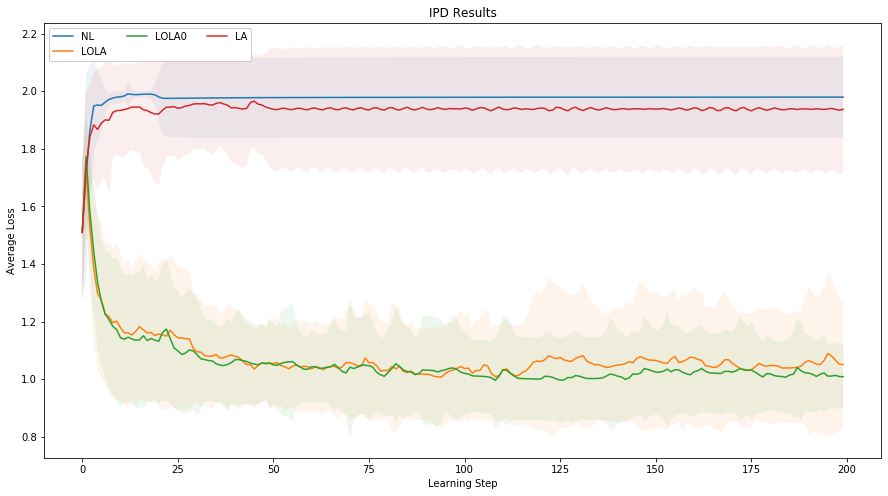

Jax time: 64.21372580528259


{'la': array([[1.63193405, 1.89570212, 1.87183928, ..., 1.9994061 , 1.99941099,
         1.99941397],
        [1.82967412, 1.86369836, 2.00822973, ..., 1.99942136, 1.99942183,
         1.99942338],
        [1.21151888, 1.28242218, 1.40303051, ..., 1.99947202, 1.99947643,
         1.99948204],
        ...,
        [1.55459106, 1.4888221 , 1.70354462, ..., 1.99939668, 1.99939644,
         1.99940109],
        [1.6288321 , 1.48504055, 1.57893872, ..., 1.99958777, 1.99959099,
         1.99959254],
        [1.72288048, 1.71158504, 1.5901581 , ..., 1.99942029, 1.99942577,
         1.99942648]]),
 'lola': array([[1.63193405, 1.7559365 , 1.62300837, ..., 1.00307965, 1.00309694,
         1.00311553],
        [1.82967412, 1.9151938 , 1.6196878 , ..., 1.00469148, 1.00455749,
         1.00442958],
        [1.21151888, 1.47803855, 1.68131042, ..., 1.00143337, 1.00141704,
         1.00140476],
        ...,
        [1.55459106, 1.7369976 , 1.41874266, ..., 0.49501398, 0.49513179,
         0.49526176]

In [2]:
''' ######## IPD ######## '''
game = 'ipd'
std = 1
num_runs = 50
num_epochs = 200
gamma = 0.96

dims, Ls = game_fn[game]()
theta = vmap(partial(init_th, dims, std))(jax.random.split(rng, num_runs))
theta0 = jp.zeros_like(theta)


alpha=1.0
eta=1.0
beta=0.0

update_fn = {
    'la':jit(vmap(partial(update_th, 'la', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
    'lola':jit(vmap(partial(update_th, 'lola', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
    'lola0':jit(vmap(partial(update_th, 'lola0', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
    'nl':jit(vmap(partial(update_th, 'nl', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0)))
}

def plot_ipd(algolist, mode='0'):
    lossalgomap={}
    t1 = time.time()
    plt.figure(figsize=(15, 8))
    for algo in [s.lower() for s in algolist]:
        print(algo)
        losses_out = np.zeros((num_runs, num_epochs))
        th, th0 = theta, theta0
        for k in range(num_epochs):
            th, th0, losses = update_fn[algo](th, th0)
            if mode == '0':
                losses_out[:, k] = (1-gamma)*losses[:, 0]
            elif mode == '1':
                losses_out[:, k] = (1 - gamma) * losses[:, 1]
            else:
                losses_out[:, k] = (1 - gamma) * jp.mean(losses, axis=1)
        lossalgomap[algo]=losses_out
        mean = np.mean(losses_out, axis=0)
        dev = np.std(losses_out, axis=0)
        plt.plot(np.arange(num_epochs), mean)
        plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

    plt.title('IPD Results')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
    plt.legend(algolist, loc='upper left', frameon=True, framealpha=1, ncol=3)
    plt.show()
    print('Jax time:', time.time()-t1)
    return lossalgomap
algolist = ['NL', 'LOLA', 'LOLA0', 'LA']
plot_ipd(algolist)
